In [ ]:
### DETERMINING TECHNIQUE FOR DETECTING RIBBON ###


Processing: ppt9.jpg


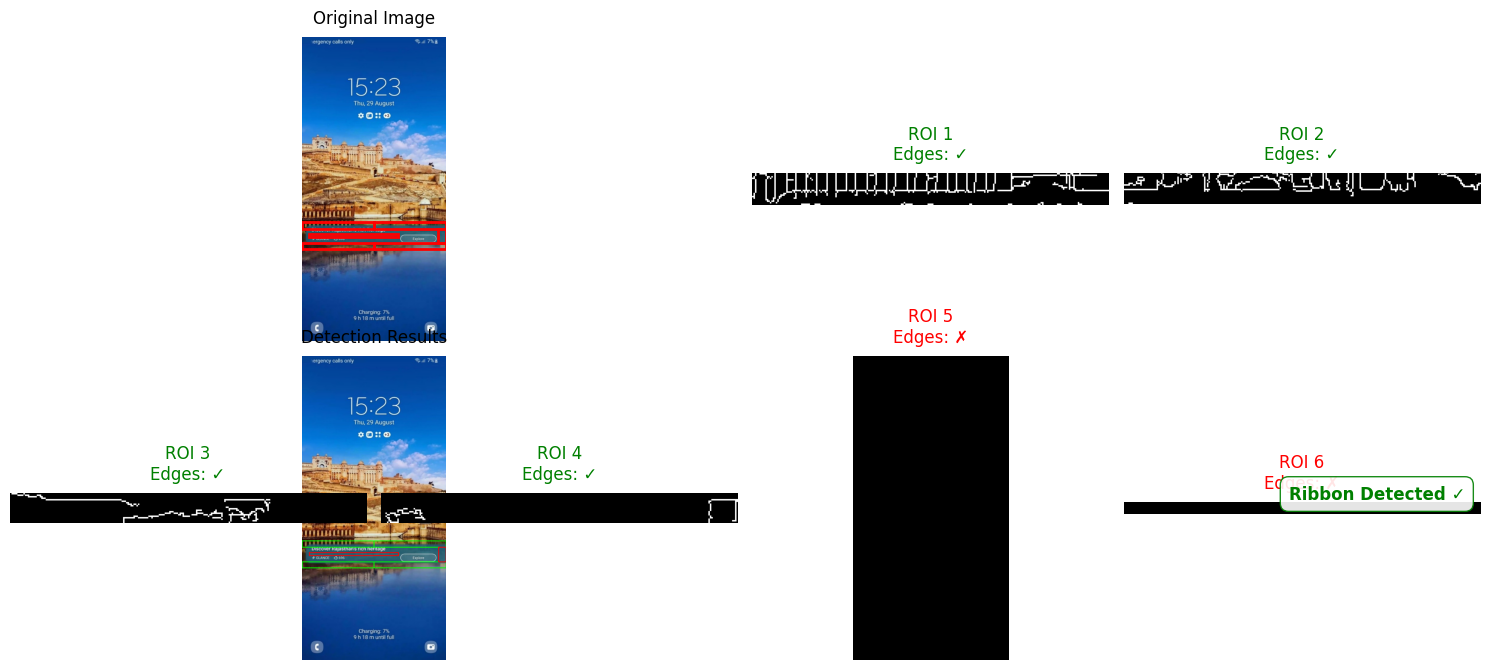

Result: Ribbon detected ✓

Processing: ppt8.jpg


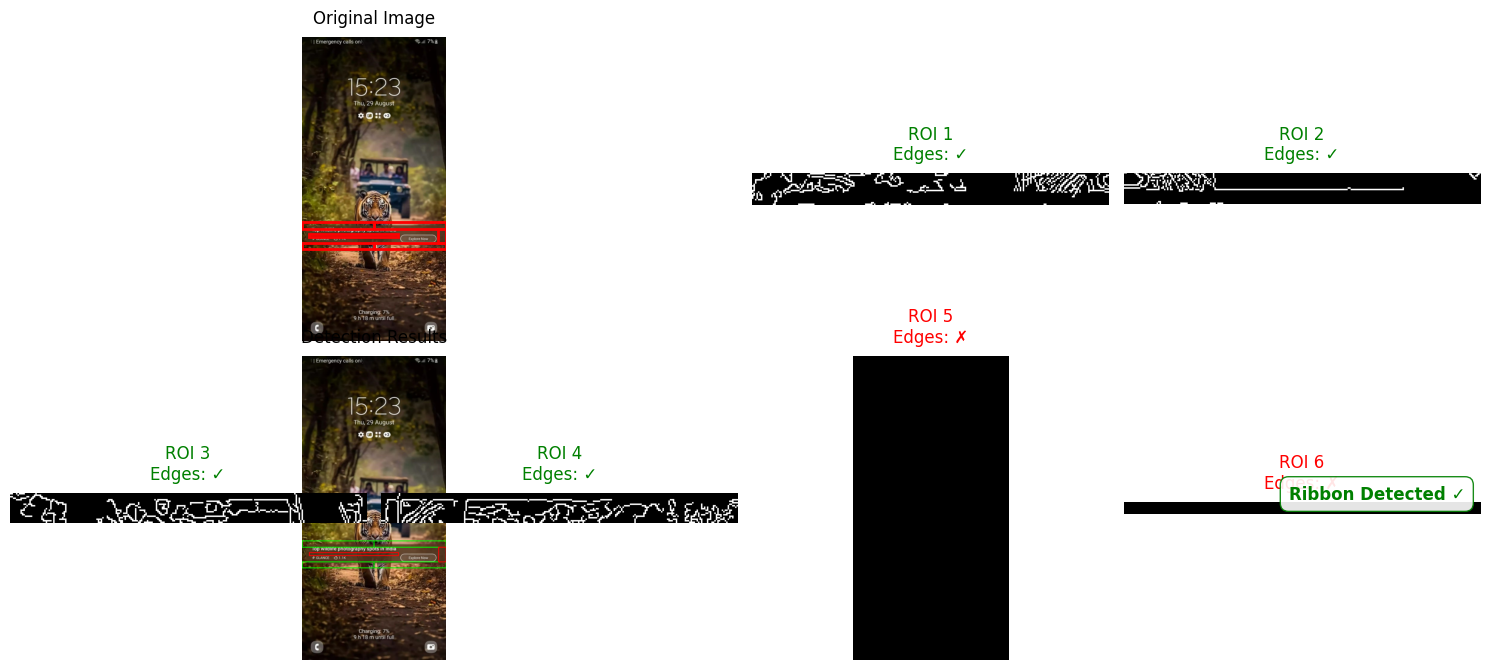

Result: Ribbon detected ✓

Processing: noread2.jpg


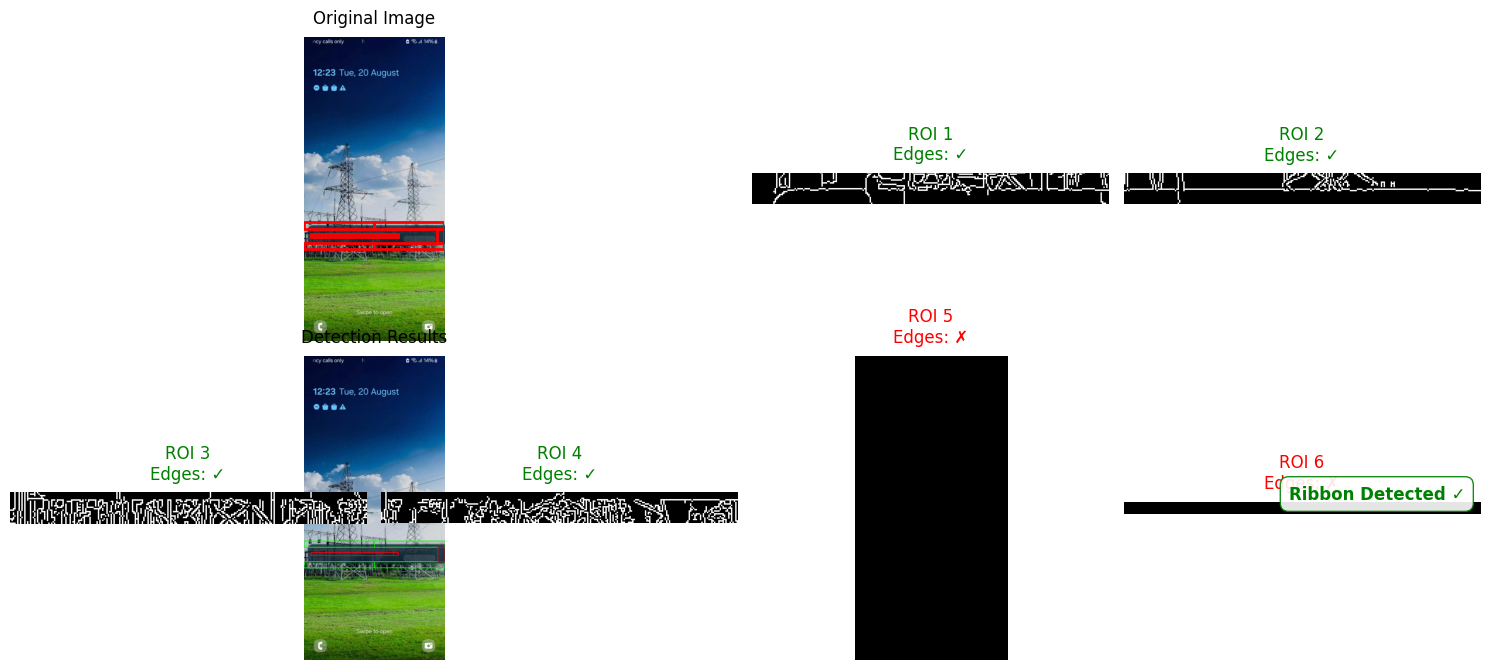

Result: Ribbon detected ✓

Processing: pixelcut-export (10).png


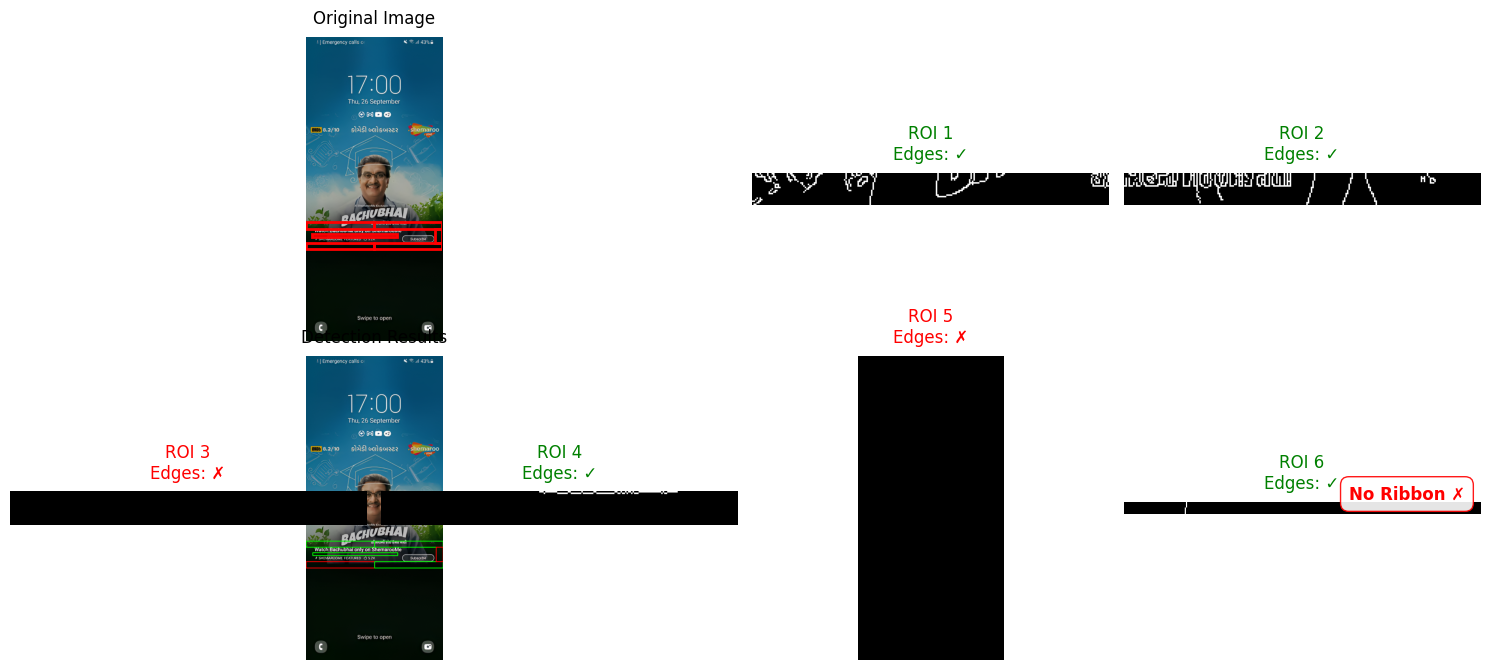

Result: No ribbon ✗

Processing: pixelcut-export (4).jpeg


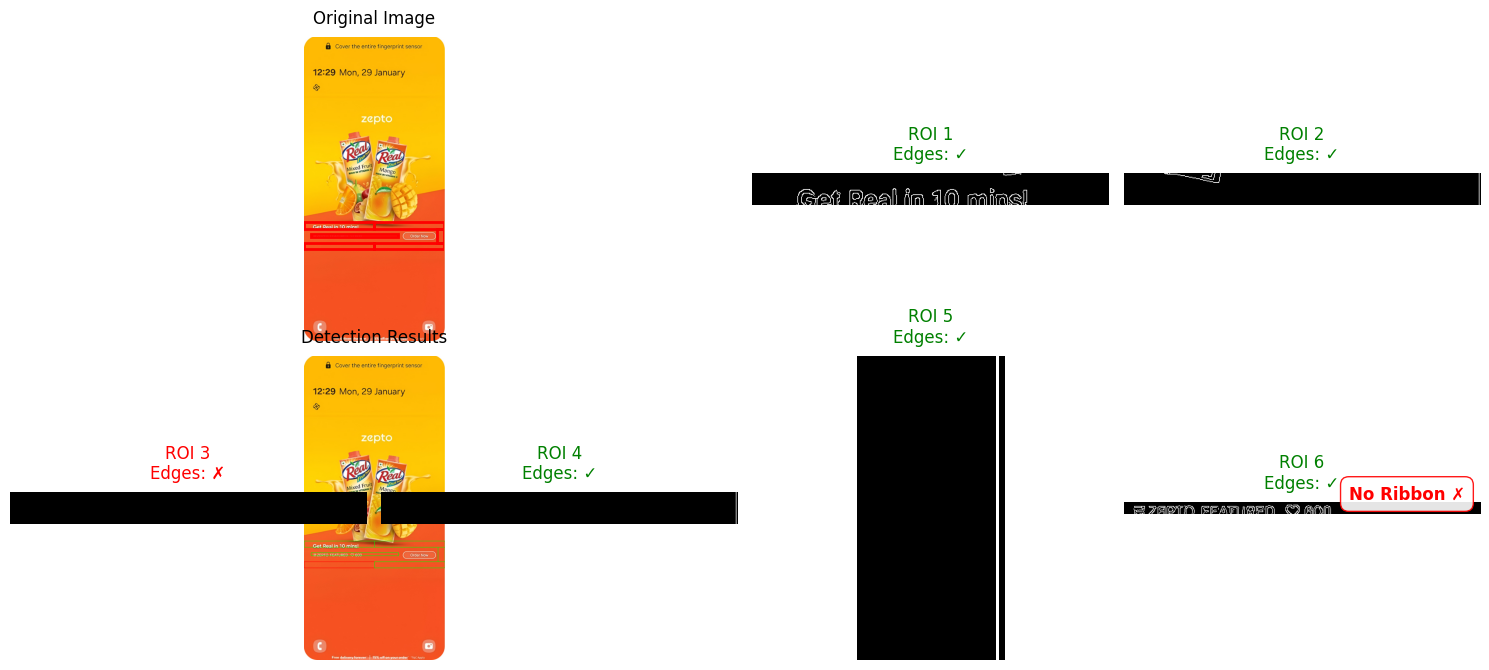

Result: No ribbon ✗

Processing: Screenshot_20241021-142831_One UI Home.jpg


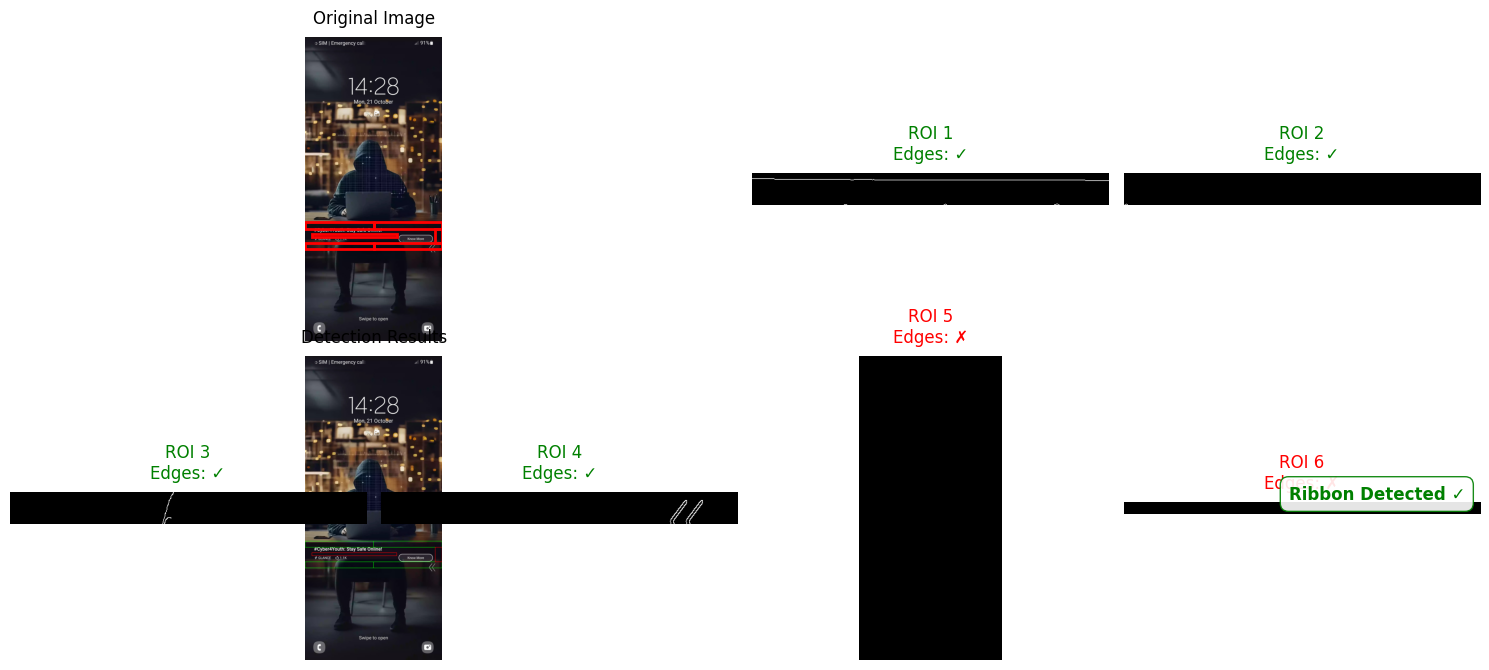

Result: Ribbon detected ✓

Processing: pixelcut-export (4).png


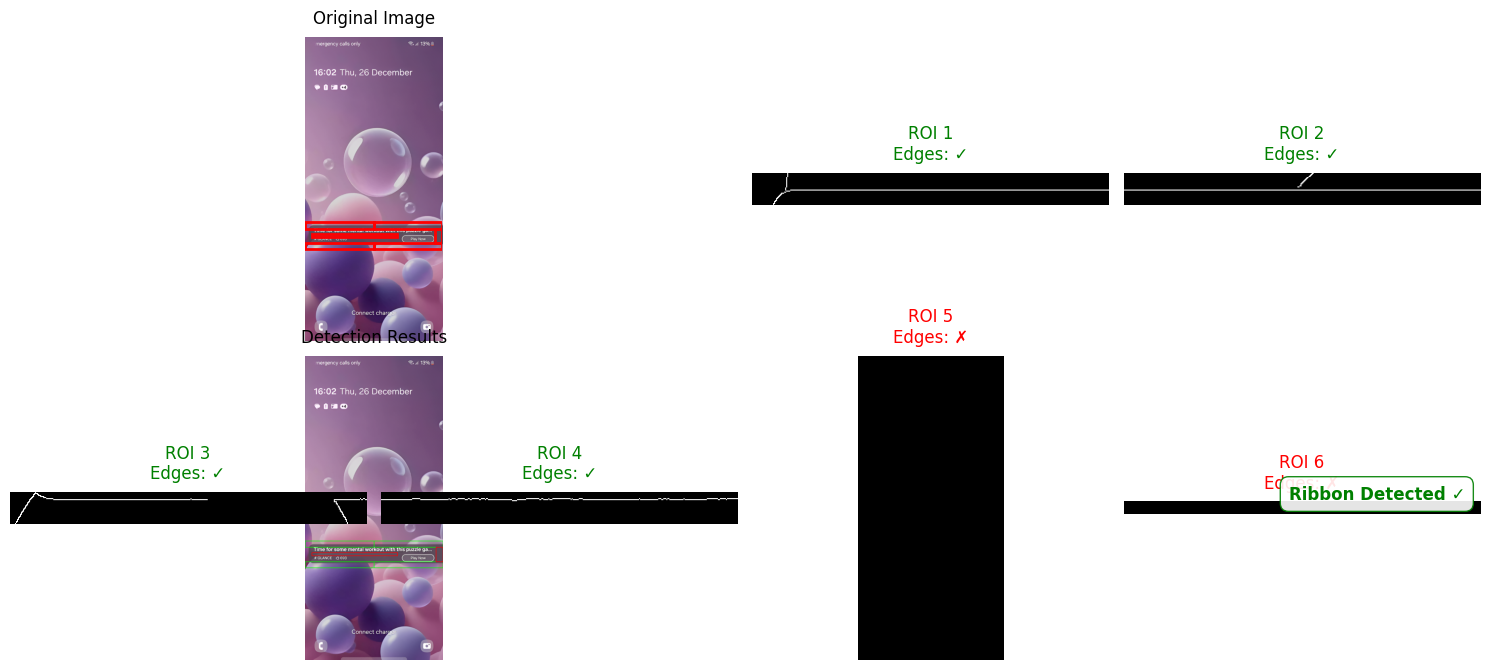

Result: Ribbon detected ✓

Processing: NoTag2.jpg


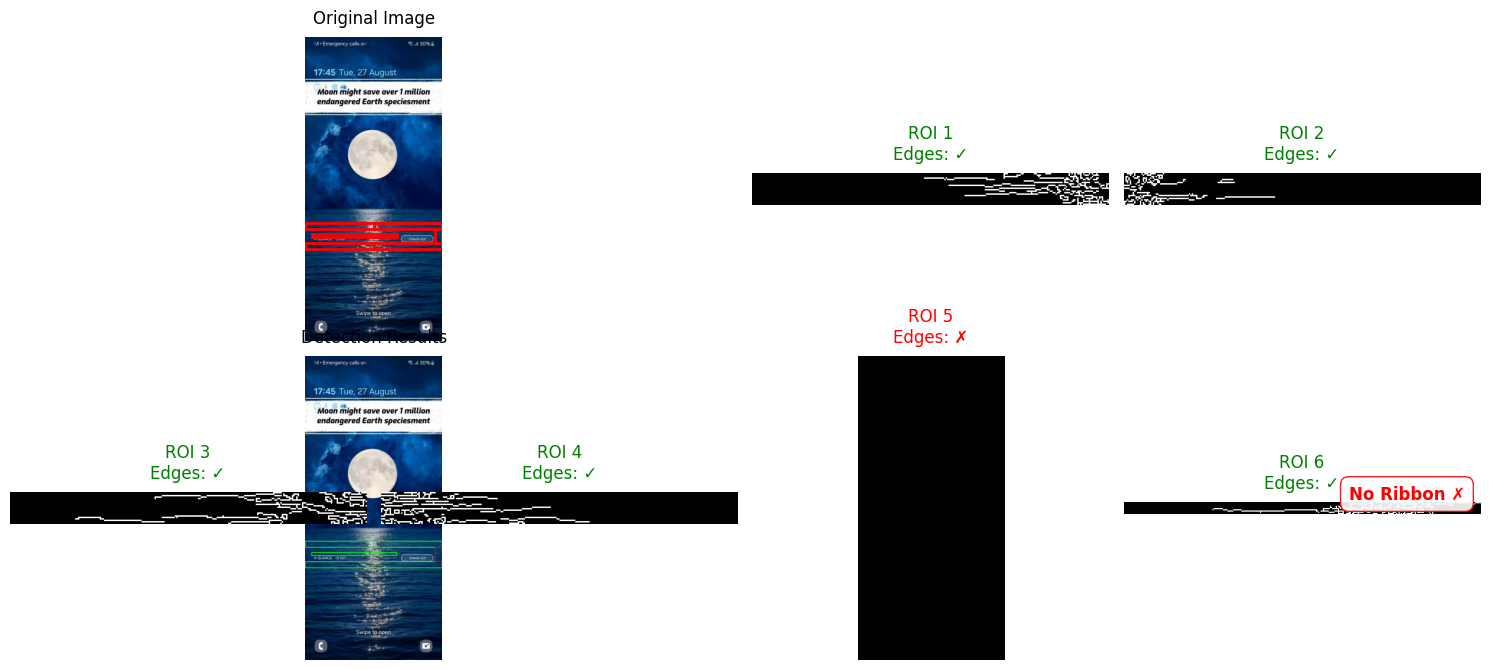

Result: No ribbon ✗

Processing: ppt10.jpg


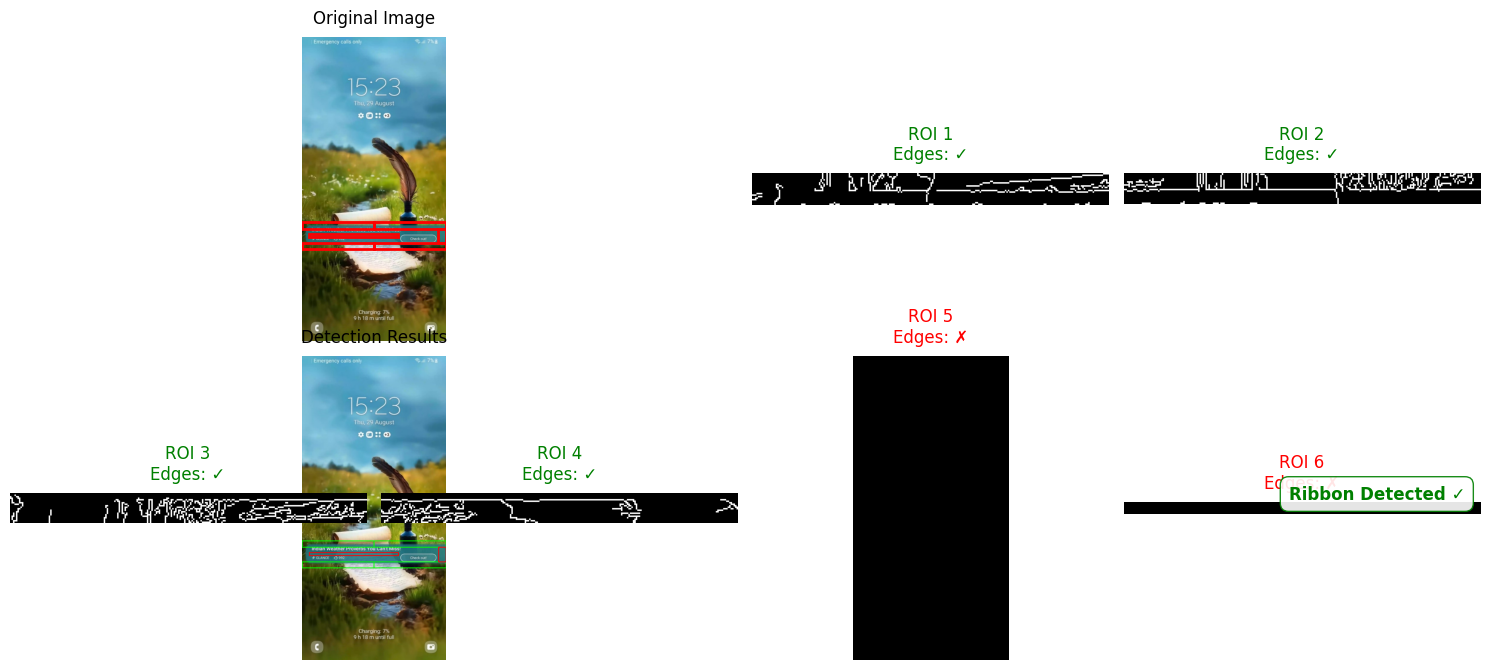

Result: Ribbon detected ✓

Processing: pixelcut-export (2).png


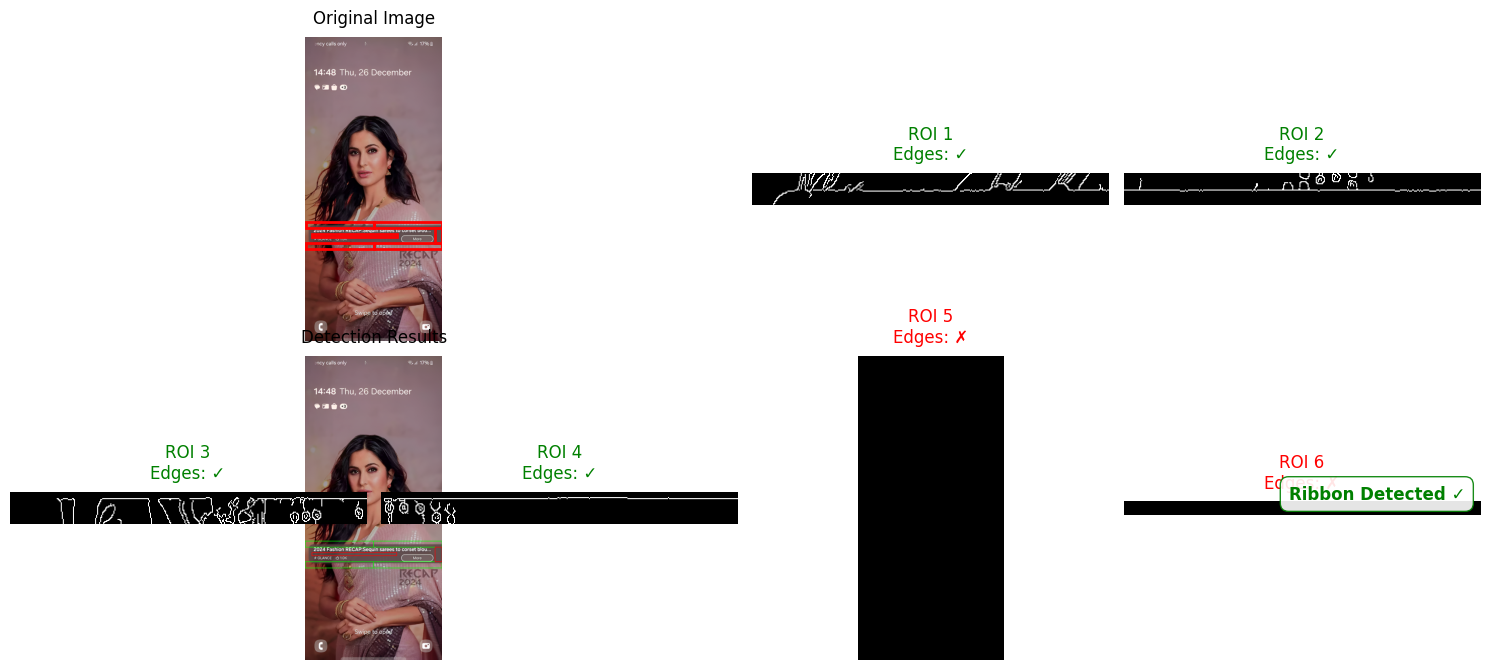

Result: Ribbon detected ✓

Processing: pixelcut-export (3).png


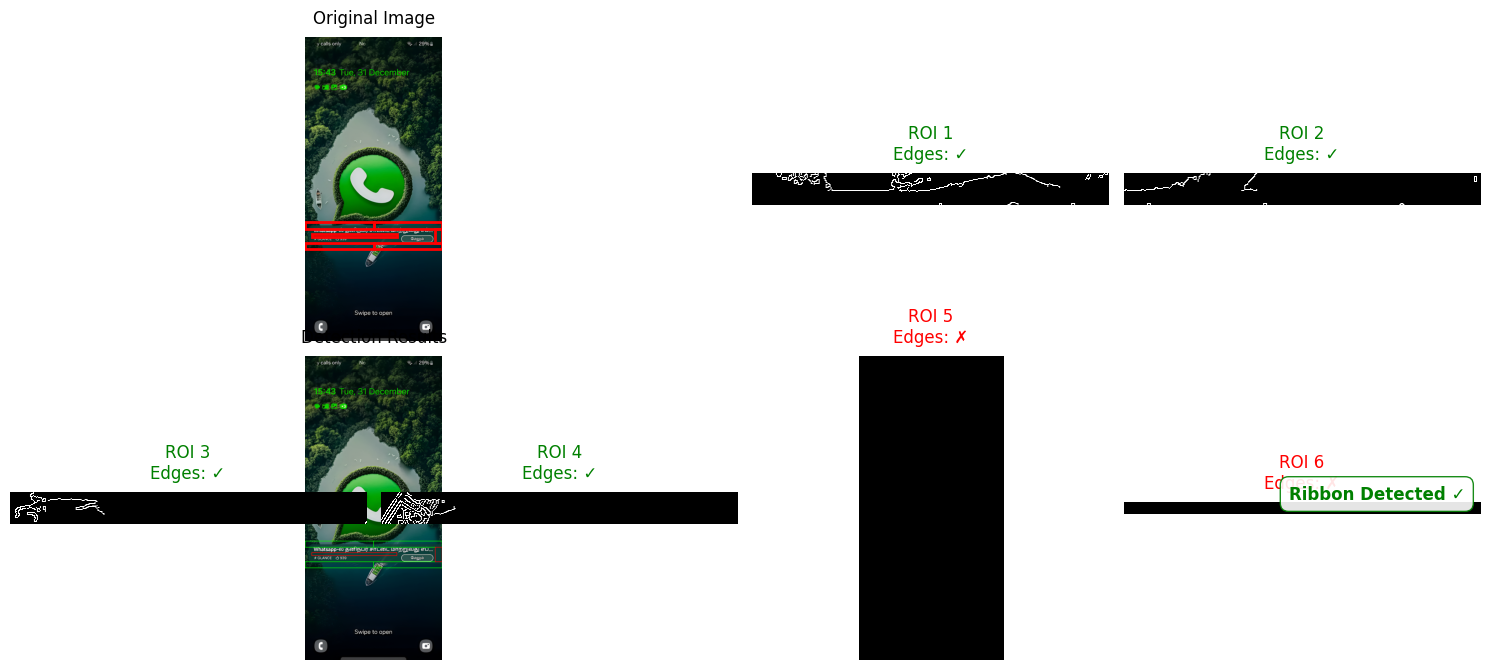

Result: Ribbon detected ✓


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os

ROIS = [
    (0.0, 0.61, 0.5, 0.63),  # Top section
    (0.5, 0.61, 1, 0.63),
    (0.0, 0.678, 0.5, 0.698),  # Bottom section
    (0.5, 0.678, 1, 0.698),
    (0.95, 0.63, 1, 0.678),  # Extreme Right section
    (0.05, 0.648, 0.67, 0.658)  # Middle Section (between Tag and Click)
]

def process_and_display(image_path):
    image = cv2.imread(image_path)
    if image is None: return {"Ribbon": 0}

    h, w = image.shape[:2]
    sub_rois = []
    edge_present = []
    roi_images = []

    for roi in ROIS:
        x1, y1, x2, y2 = [int(coord * (w if i % 2 == 0 else h)) for i, coord in enumerate(roi)]
        roi_img = image[y1:y2, x1:x2]
        roi_images.append(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
        edges = cv2.Canny(cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY), 50, 150)
        sub_rois.append(edges)
        edge_present.append(np.any(edges))

    fig = plt.figure(figsize=(15, 10))  # Adjusted figure size for 6 ROIs
    gs = GridSpec(3, 4, figure=fig)  # 3x4 grid to accommodate 6 ROIs

    plt.subplot(gs[0, :2])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image", pad=10)
    for i, roi in enumerate(ROIS):
        x1, y1, x2, y2 = [int(coord * (w if i % 2 == 0 else h)) for i, coord in enumerate(roi)]
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                          fill=False, color='red', linewidth=2))
    plt.axis('off')

    plt.subplot(gs[1, :2])
    img_copy = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).copy()
    for i, (roi, present) in enumerate(zip(ROIS, edge_present)):
        x1, y1, x2, y2 = [int(coord * (w if i % 2 == 0 else h)) for i, coord in enumerate(roi)]
        color = (0, 255, 0) if present else (255, 0, 0)
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, 2)
    plt.imshow(img_copy)
    plt.title("Detection Results", pad=10)
    plt.axis('off')

    # Adjusting the number of columns for ROI images and edge detections
    for i, (roi_img, edges, present) in enumerate(zip(roi_images, sub_rois, edge_present)):
        plt.subplot(gs[(i + 2) // 4, (i + 2) % 4])  # Adjust indices for subplot positions
        plt.imshow(edges, cmap='gray')
        color = 'green' if present else 'red'
        plt.title(f"ROI {i+1}\nEdges: {'✓' if present else '✗'}",
                color=color, pad=10)
        plt.axis('off')

    # Result condition: Top and bottom sections should have edges, and the last two sections should not
    result = all(edge_present[:4]) and not any(edge_present[4:])
    status_text = 'Ribbon Detected ✓' if result else 'No Ribbon ✗'
    status_color = 'green' if result else 'red'
    plt.figtext(0.98, 0.5, status_text,
                color=status_color, fontsize=12, fontweight='bold',
                ha='right', va='center',
                bbox=dict(facecolor='white', alpha=0.9,
                        edgecolor=status_color, boxstyle='round,pad=0.5'))

    plt.tight_layout()
    plt.show()

    return {"Ribbon": 1 if result else 0}

def process_directory(directory):
    images = [f for f in os.listdir(directory) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    results = {}
    for img in images:
        path = os.path.join(directory, img)
        print(f"\nProcessing: {img}")
        results[img] = process_and_display(path)
        print(f"Result: {'Ribbon detected ✓' if results[img]['Ribbon'] else 'No ribbon ✗'}")
    return results

# Usage
directory = '/content'  # Replace with your directory
results = process_directory(directory)
